In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from energyflow.archs import EFN
from energyflow.utils import data_split

2023-10-09 15:35:07.716587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def read_data(file_path):
    data_file = open(file_path)
    lno = 0
    pTvals = []
    etavals = []
    phivals = []
    tvals = []
    events_input=[]
    events_target=[]
    data = []

    for line in data_file:
        lno+=1
        if (lno > 1000000000):
            break
        # enumber = int(line.split()[0])
        isprime = int(line.split()[1])
        E = float(line.split()[2])
        px = float(line.split()[3])
        py = float(line.split()[4])
        pz = float(line.split()[5])
        t = float(line.split()[6])
        
        pT = math.sqrt( px**2 + py**2 )
        p = math.sqrt( px**2 + py**2 + pz**2 )
        
        if (pz > 0):    
            eta = math.acosh(p / pT)
        else:
            eta = -math.acosh(p / pT)
        phi = math.atan( py / px )
        
        if (isprime==1):
            pTvals += [pT]
            etavals += [eta]
            phivals += [phi]
            tvals += [t]
            data += [[pT,eta,phi,t]]
        if (isprime==0):
            events_target += [[t]] 
            if (lno > 1):
                events_input += [data]
            data=[]

    events_input += [data]

    return events_input, events_target



In [3]:
def zero_padding(raw_data, max_num):

    input_zp = np.zeros([max_num,40,4])

    for i in range(0, max_num):
        for j in range(min(40,len(raw_data[i]))):
            input_zp[i,j,:] = raw_data[i][j]
        # np.random.shuffle(input_zp[i,:,:])

    return input_zp

In [4]:
def normalization(input, target, max_num, factor):

    pT_weighted_time = []
    axis_eta = []

    for jet in input:
        mask = jet[:,0] > 0
        yphi_avg = np.average(jet[mask,1:3], weights=jet[mask,0], axis=0)
        axis_eta += [[yphi_avg[0]]]
        jet[mask,1:3] -= yphi_avg
        
        t_avg = np.average(jet[mask,3], weights=jet[mask,0], axis=0) 
        jet[mask,3] /= t_avg
        jet[mask,3] -= 1
        jet[mask,0] /= jet[:,0].sum()

        pT_weighted_time += [[t_avg*factor]]

    target = np.array(target[:max_num])
    target_scaled = target * factor
    pT_weighted_time = np.array(pT_weighted_time)
    axis_eta = np.array(axis_eta)

    return axis_eta, pT_weighted_time, input, target_scaled

In [5]:
def preprocessing(input_path_list, max_num):

    data_input_dict = {}
    data_globale_dict = {}
    data_globalt_dict = {}
    data_label_dict = {}
    data_rtd_dict = {}
    factor = 0
    for key, data_path in enumerate(input_path_list):
        
        raw_input, raw_label = read_data(data_path)
        input_zp = zero_padding(raw_input, max_num)

        factor = 1e8    
        axis_eta, pTweighted_time, input_scaled, label_scaled = normalization(input_zp, raw_label, max_num, factor)

        data_input_dict["input"+data_path] = input_scaled
        data_globale_dict["globale"+data_path] = axis_eta
        data_globalt_dict["globalt"+data_path] = pTweighted_time
        data_label_dict["label"+data_path] = label_scaled
        data_rtd_dict["rtd"+data_path] = (np.array(pTweighted_time) / (np.array(raw_label[:max_num])*factor) ) -1


    return data_rtd_dict, data_input_dict, data_globale_dict, data_globalt_dict, data_label_dict

In [6]:
def mixture(input_dict, globale_dict, globalt_dict, label_dict, train_fraction):

    mixed_input = []
    mixed_label = []
    mixed_globale = []
    mixed_globalt = []
    individual_input_list = []
    individual_label_list = []
    individual_globale_list = []
    individual_globalt_list = []

    for input_config in input_dict.values():
        
        train_len = int(len(input_config) * train_fraction)
        if (len(mixed_input) != 0):
            mixed_input = np.concatenate((mixed_input, input_config[0:train_len]), axis=0)
            # train_len = 0
        else:
            mixed_input = input_config[0:train_len]

        individual_input_list.append(input_config[train_len:])
            
    for label_config in label_dict.values():

        train_len = int(len(label_config) * train_fraction) 
        if (len(mixed_label) != 0):
            mixed_label = np.concatenate((mixed_label, label_config[0:train_len]), axis=0)
        else:
            mixed_label = label_config[0:train_len]

        individual_label_list.append(label_config[train_len:])

    for globale_config in globale_dict.values():

        train_len = int(len(globale_config) * train_fraction) 
        if (len(mixed_globale) != 0):
            mixed_globale = np.concatenate((mixed_globale, globale_config[0:train_len]), axis=0)
        else:
            mixed_globale = globale_config[0:train_len]

        individual_globale_list.append(globale_config[train_len:])

    for globalt_config in globalt_dict.values():

        train_len = int(len(globalt_config) * train_fraction) 
        if (len(mixed_globalt) != 0):
            mixed_globalt = np.concatenate((mixed_globalt, globalt_config[0:train_len]), axis=0)
        else:
            mixed_globalt = globalt_config[0:train_len]

        individual_globalt_list.append(globalt_config[train_len:])
            
         
    return mixed_input, mixed_globale, mixed_globalt, mixed_label, individual_input_list, individual_globale_list, individual_globalt_list, individual_label_list

In [7]:
input_path_list = []


eta_M = 0
x_t = 500
for eta_J in range (-20, 25, 5):
    file_path = f"/root/jettiming/ScriptForDecaying/fixed_xt_{x_t}_etaM_{eta_M}/clustered_etaM_{eta_M}_etaJ_{eta_J}_xt_{x_t}/processed_delayed_jet"
    input_path_list.append(file_path)

train_fraction = 1

In [8]:
print(input_path_list)

['/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-15_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-10_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_-5_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_0_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_5_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_10_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_15_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/clustered_etaM_0_etaJ_20_xt_500/processed_delayed_jet']

In [9]:
num_jets = 35000 

rtd_dict, input_dict, globale_dict, globalt_dict, label_dict = preprocessing(input_path_list, num_jets)

(mixed_input, mixed_globale, mixed_globalt, mixed_label, 
test_input_list, test_globale_list, test_globalt_list, test_label_list) = mixture(input_dict, globale_dict, globalt_dict, label_dict, train_fraction)

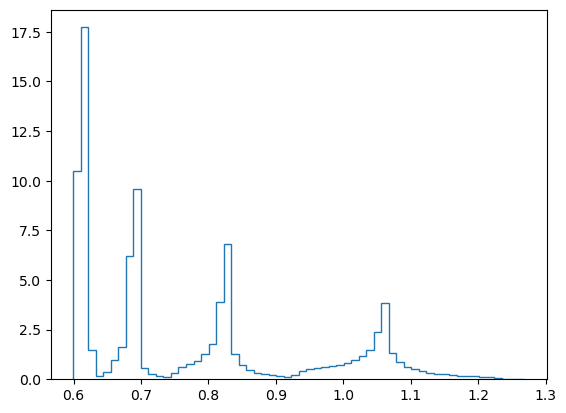

In [10]:
_,_,_=plt.hist(mixed_label,bins=60,density=True,histtype="step")
# plt.yscale('log')

In [11]:
mixed_global = np.concatenate((mixed_globale, mixed_globalt), axis=1)

In [12]:
index = 300
print(mixed_input[index])
print(mixed_globale[index])
print(mixed_globalt[index])
print(mixed_global[index])
print(mixed_label[index])

[[ 0.31557501 -0.07369499 -0.01103997  0.04569994]
 [ 0.25857432  0.08013083  0.00161215 -0.05023371]
 [ 0.14863482 -0.06318512 -0.00189088  0.03868374]
 [ 0.09758064  0.0856597   0.01351285 -0.05341569]
 [ 0.04496489 -0.00256946 -0.01131589 -0.00041246]
 [ 0.03565    -0.05619025  0.01216442  0.03406342]
 [ 0.02379289 -0.11261699 -0.02921649  0.07232169]
 [ 0.02287289  0.24604969 -0.04273716 -0.13893987]
 [ 0.02172572  0.05884994  0.06539216 -0.03758272]
 [ 0.01464922  0.03700225  0.16306388 -0.02355057]
 [ 0.00990499  0.1342429  -0.00957857 -0.08076634]
 [ 0.0060746  -0.06760081  0.01033568  0.04162807]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.  

In [13]:
train = int(0.79*len(mixed_input))
val = int(0.2*len(mixed_input))
test = len(mixed_input) - train - val


# Split the mixed data. The shuffle take place before splitting.
(z_train, z_val, z_test,
 X_train, X_val, X_test,
 G_train, G_val, G_test,
 Y_train, Y_val, Y_test) = data_split(mixed_input[:,:,0], mixed_input[:,:,1:], mixed_global, mixed_label, 
 val=val, test=test, shuffle = True)

In [14]:
Phi_sizes, F_sizes = (200, 200, 200), (200, 200, 200)
output_act = 'linear'
loss = 'mse'

In [15]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.00005)

In [16]:
mixed_efn = EFN(input_dim=3, Phi_sizes=Phi_sizes, F_sizes=F_sizes,
         output_act=output_act, output_dim=1, loss=loss, metrics=[], optimizer = opt, num_global_features = 2)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 200)    800         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 200)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 200)    40200       ['activation[0][0]']             
                                                                                              

2023-10-09 15:36:31.490790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 15:36:31.491977: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
num_epoch = 300
batch_size = 1000

hist =  mixed_efn.fit([z_train, X_train, G_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, X_val, G_val], Y_val),
        verbose=1,shuffle = True)

Epoch 1/300
249/249 [==============================] - 104s 416ms/step - loss: 0.0262 - val_loss: 1.7845e-04
Epoch 2/300
249/249 [==============================] - 98s 394ms/step - loss: 1.1030e-04 - val_loss: 7.0072e-05
Epoch 3/300
249/249 [==============================] - 99s 397ms/step - loss: 5.0221e-05 - val_loss: 3.6837e-05
Epoch 4/300
249/249 [==============================] - 101s 407ms/step - loss: 2.9997e-05 - val_loss: 2.4766e-05
Epoch 5/300
249/249 [==============================] - 101s 407ms/step - loss: 2.1823e-05 - val_loss: 1.9321e-05
Epoch 6/300
249/249 [==============================] - 101s 406ms/step - loss: 1.7334e-05 - val_loss: 1.5590e-05
Epoch 7/300
249/249 [==============================] - 105s 422ms/step - loss: 1.4324e-05 - val_loss: 1.3273e-05
Epoch 8/300
249/249 [==============================] - 99s 399ms/step - loss: 1.2270e-05 - val_loss: 1.1415e-05
Epoch 9/300
249/249 [==============================] - 100s 402ms/step - loss: 1.0782e-05 - val_loss: 1

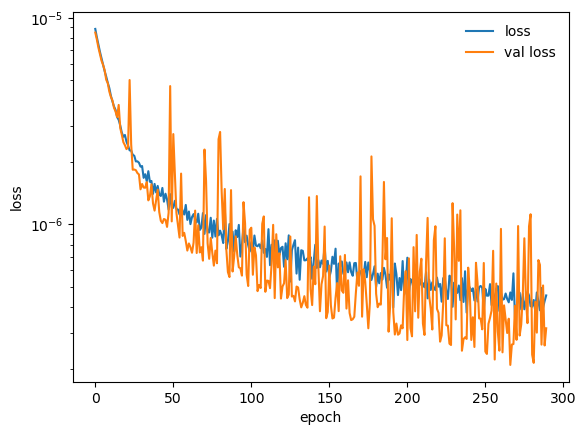

In [18]:
plt.plot(hist.history['loss'][10:],label="loss")
plt.plot(hist.history['val_loss'][10:],label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.legend(frameon=False)

In [19]:
import tensorflow as tf

mixed_efn.save('cat_etat_var_etaJ_more.h5')

In [20]:
unseenetaJ_path_list = []

for test_etaJ in range(-20, 21, 1):

    unseenetaJ_path = f'/root/jettiming/ScriptForDecaying/fixed_xt_{x_t}_etaM_{eta_M}/testdata/test_clustered_etaM_{eta_M}_etaJ_{test_etaJ}_xt_{x_t}/processed_delayed_jet'
    unseenetaJ_path_list.append(unseenetaJ_path)

In [21]:
num_test = 7000
unseen_rtd_dict, unseen_input_dict, unseen_globale_dict, unseen_globalt_dict, unseen_label_dict = preprocessing(unseenetaJ_path_list, num_test)

In [22]:
unseen_input_keylist = list(unseen_input_dict.keys())
print(unseen_input_keylist)

['input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-19_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-18_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-17_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-16_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-15_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustered_etaM_0_etaJ_-14_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_xt_500_etaM_0/testdata/test_clustere

 1/35 [..............................] - ETA: 0s

/tmp/ipykernel_2311736/941662326.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


35/35 [==============================] - 1s 21ms/step


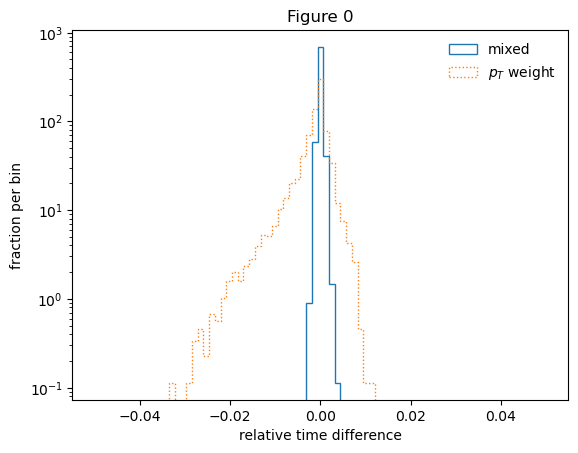

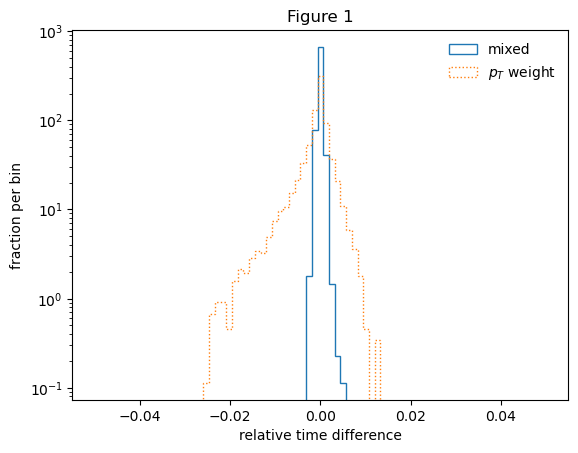

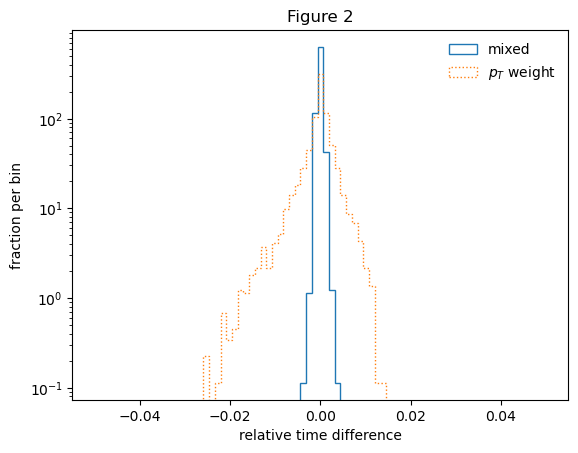

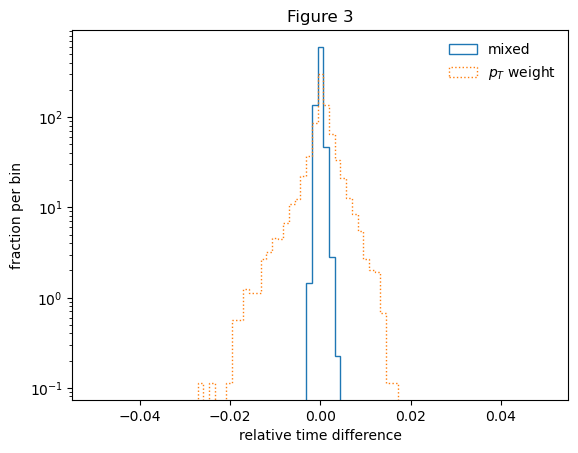

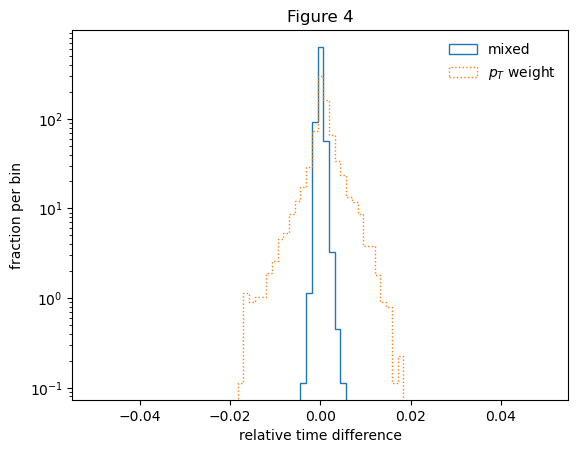

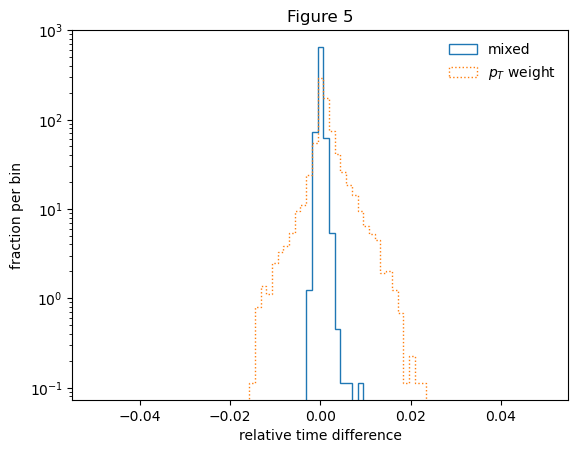

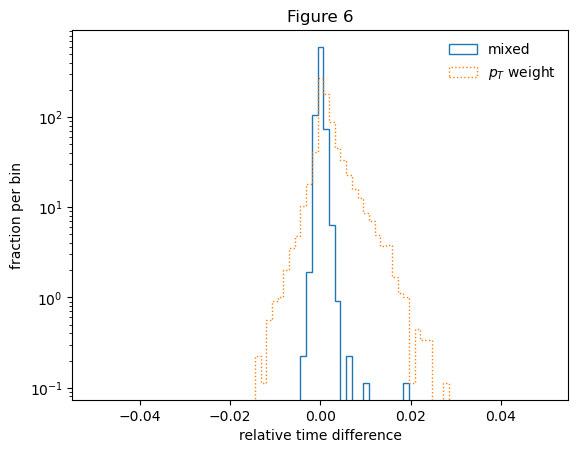

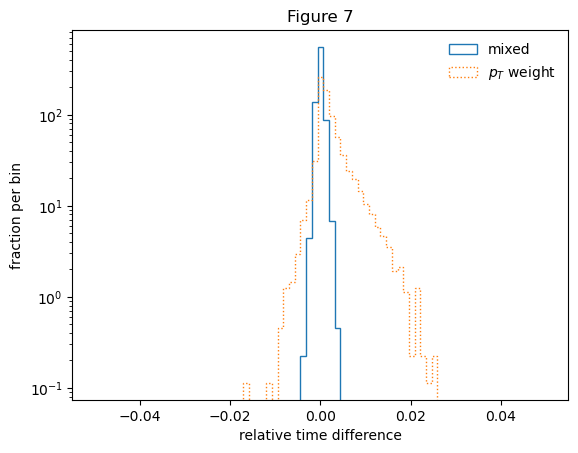

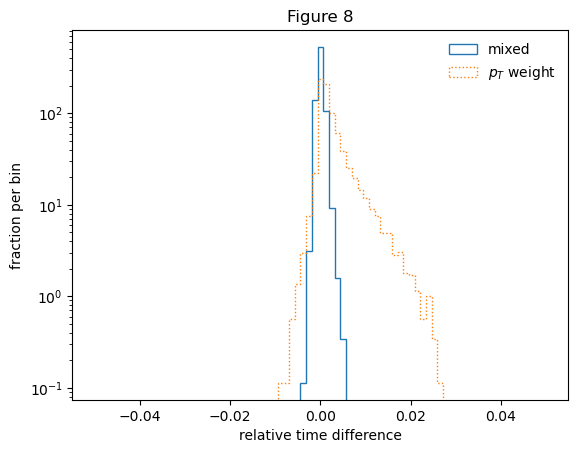

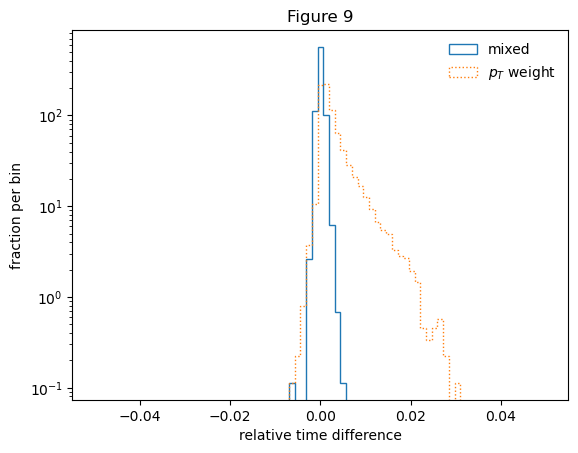

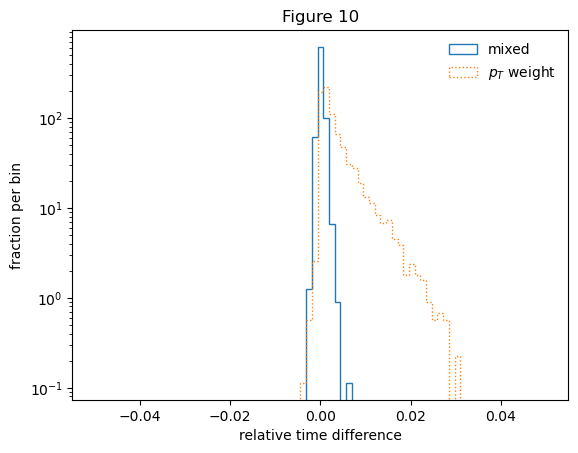

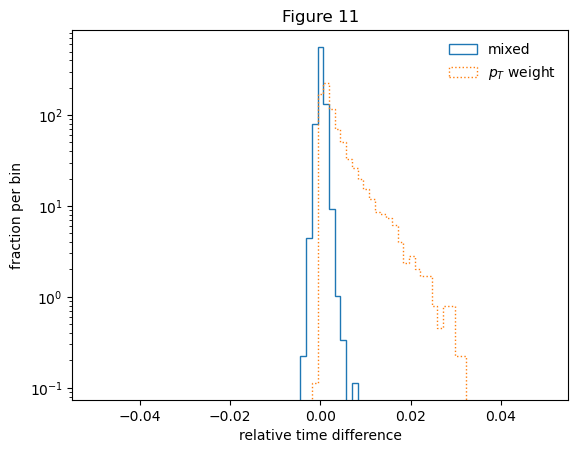

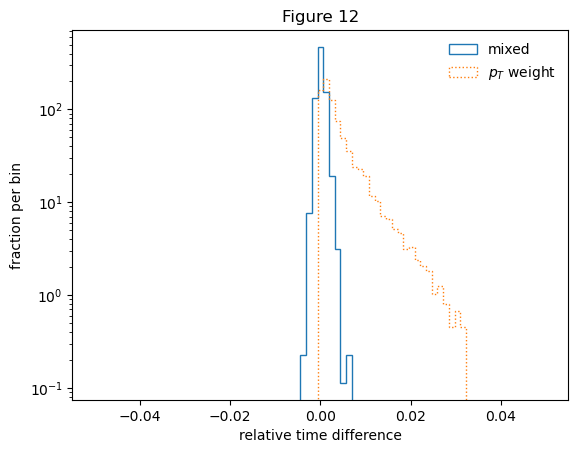

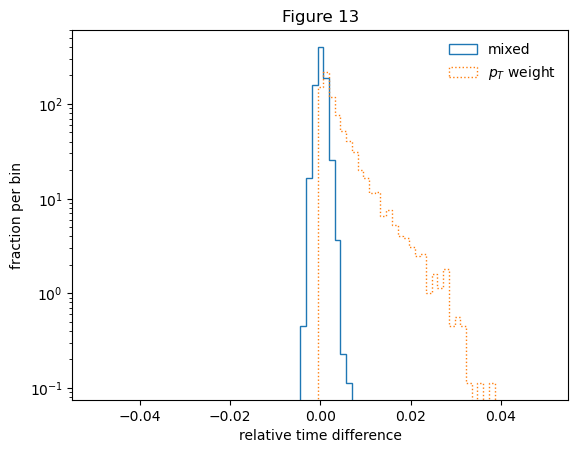

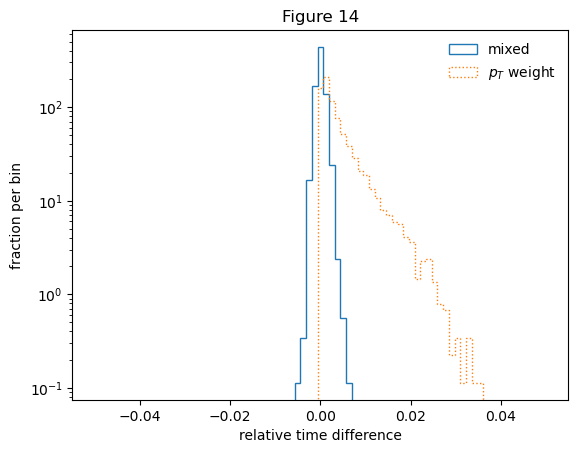

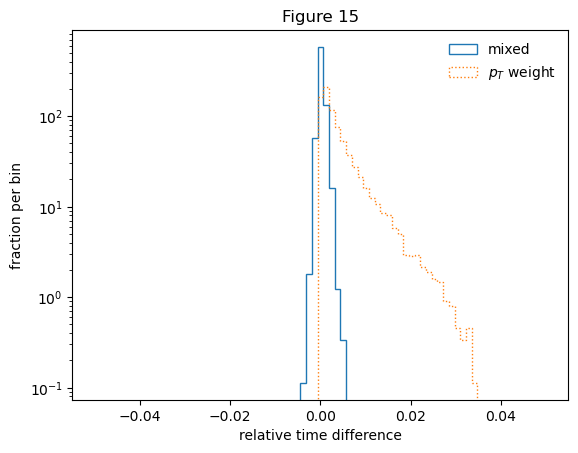

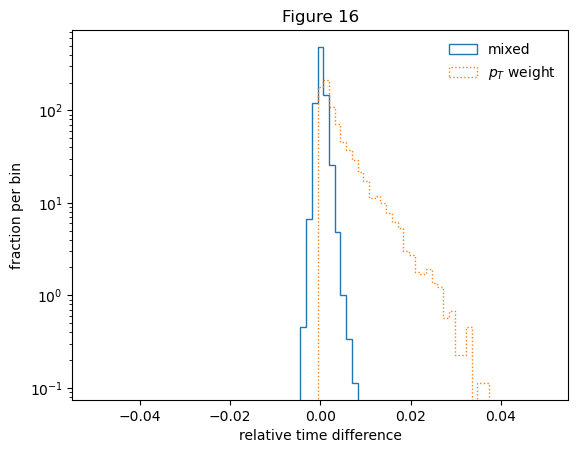

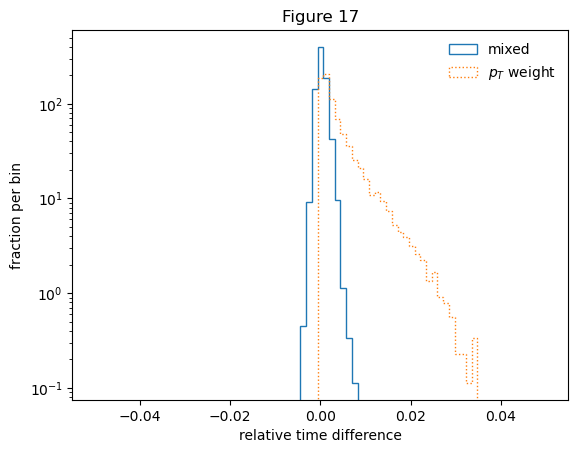

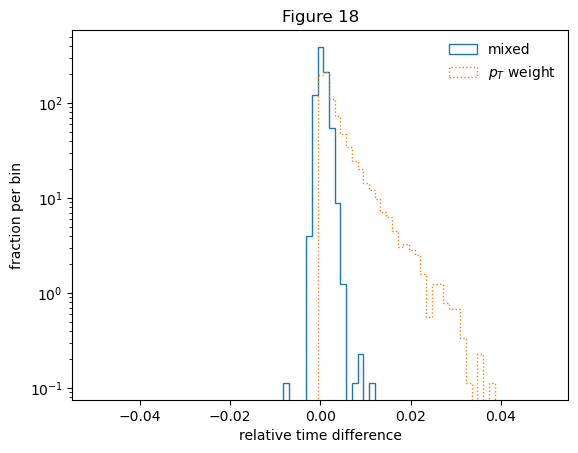

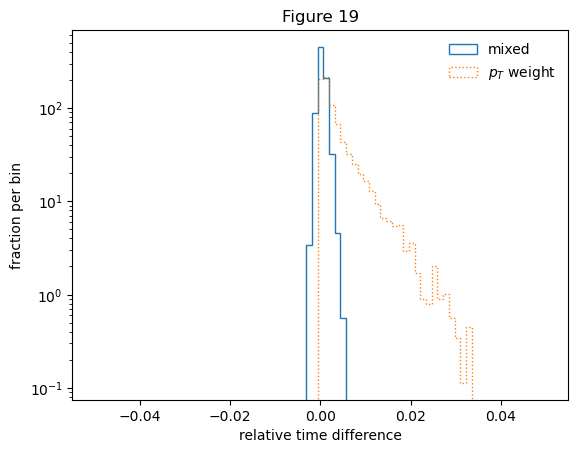

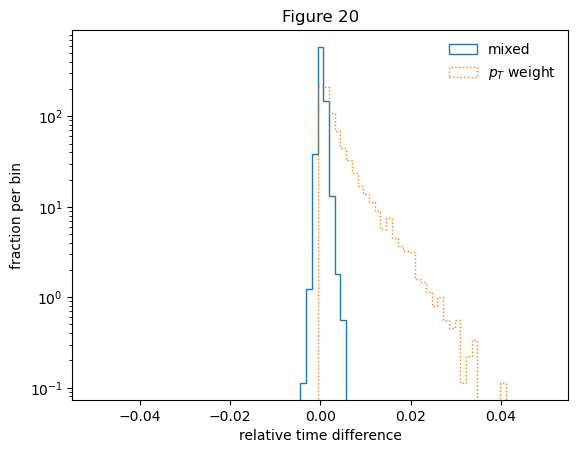

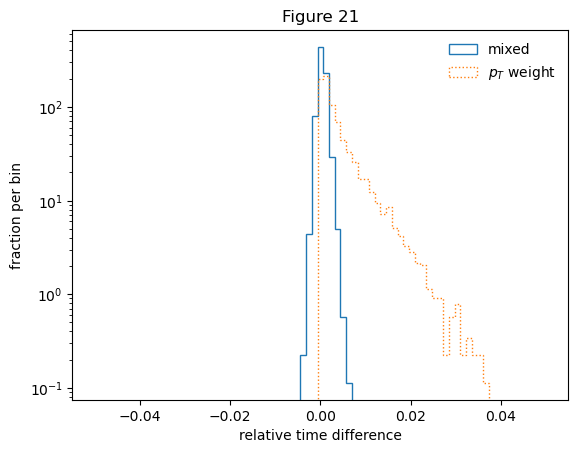

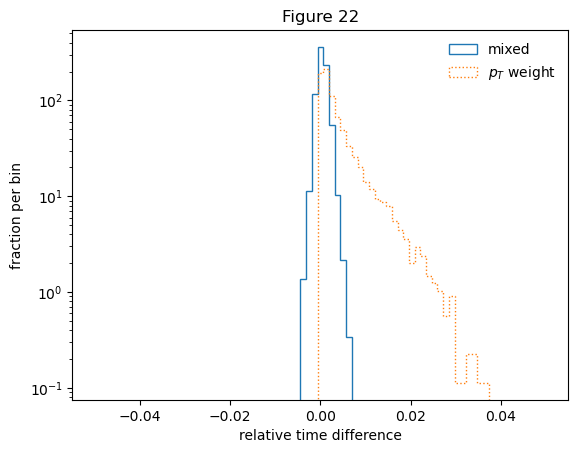

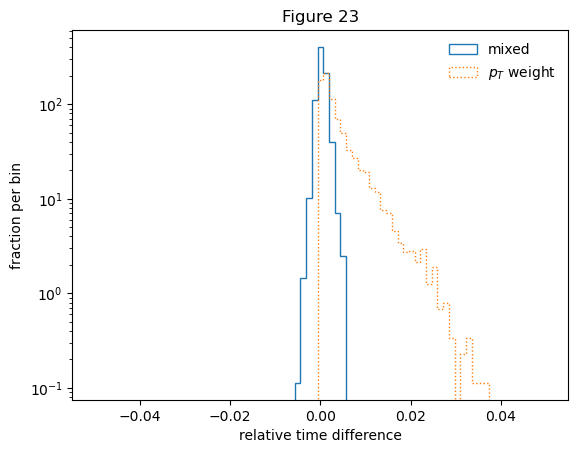

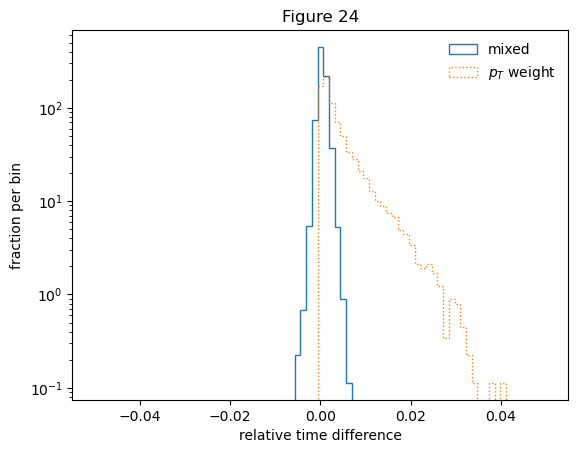

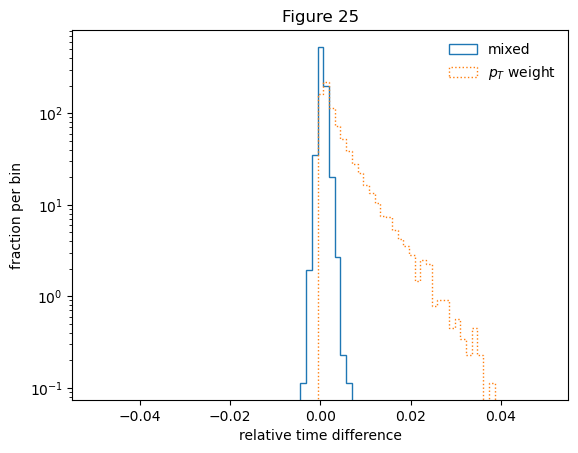

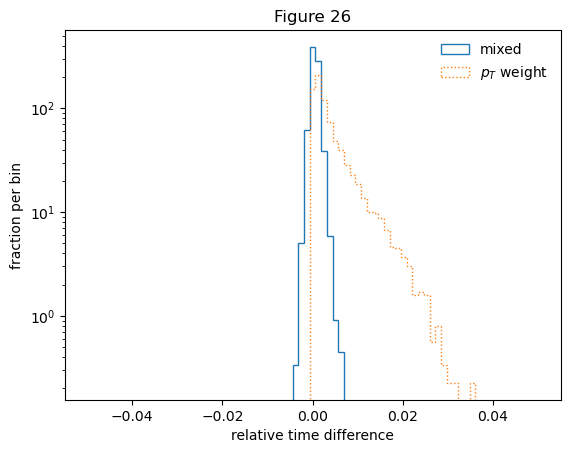

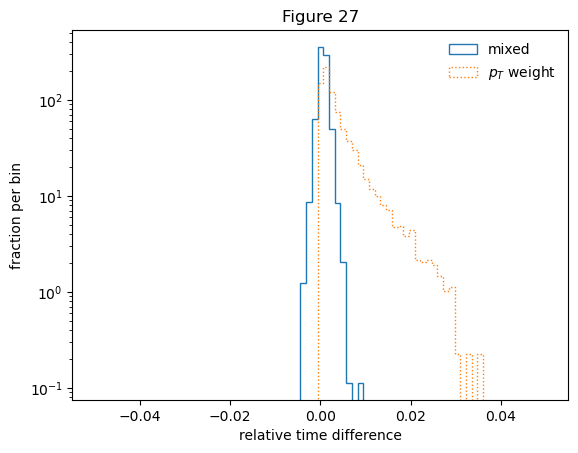

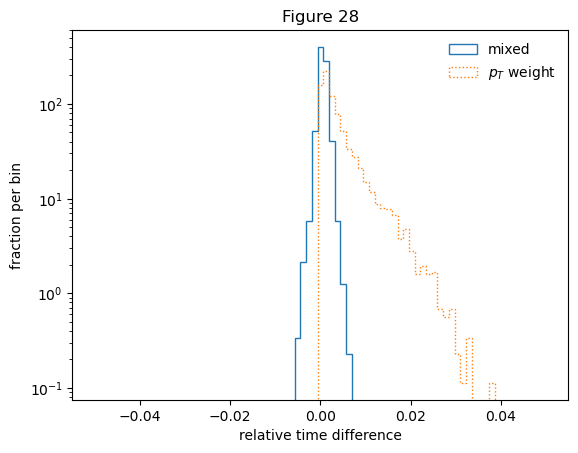

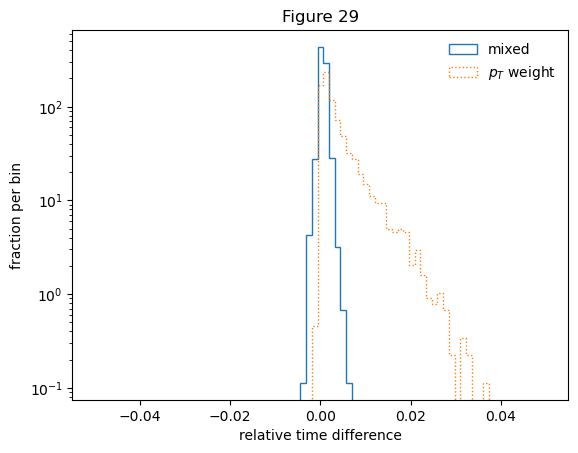

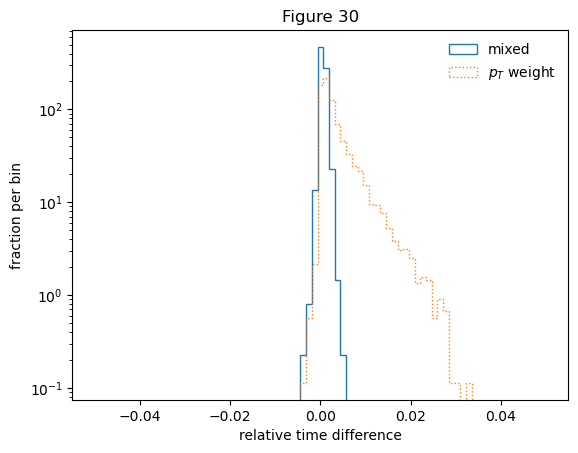

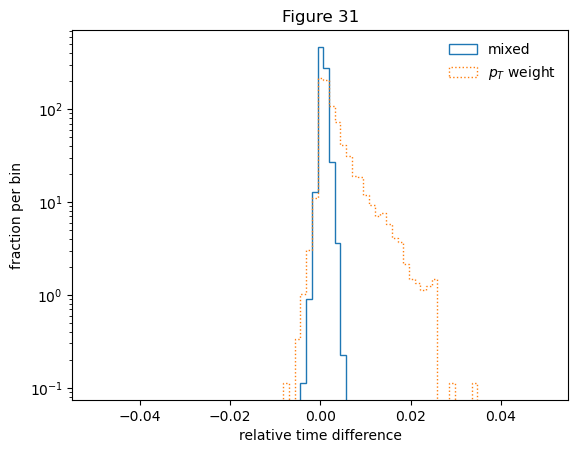

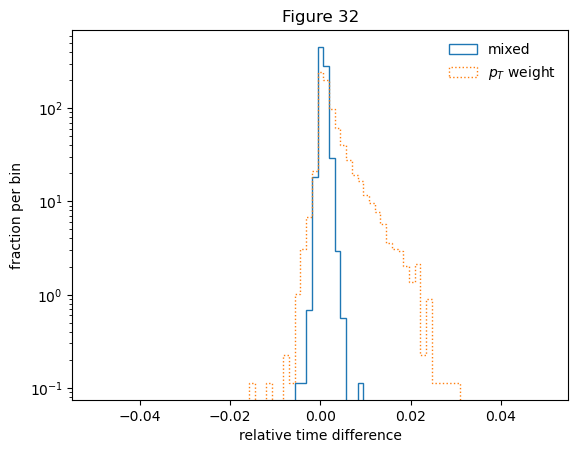

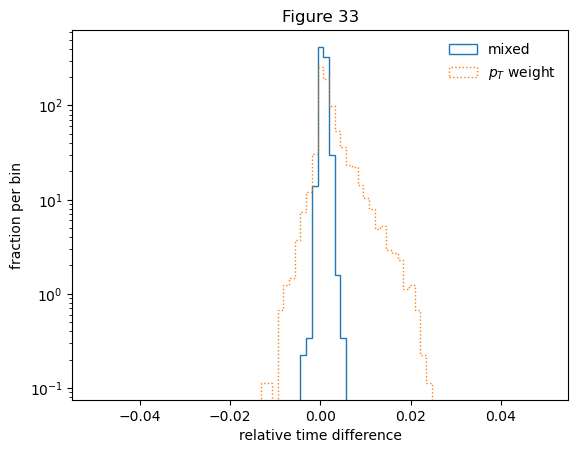

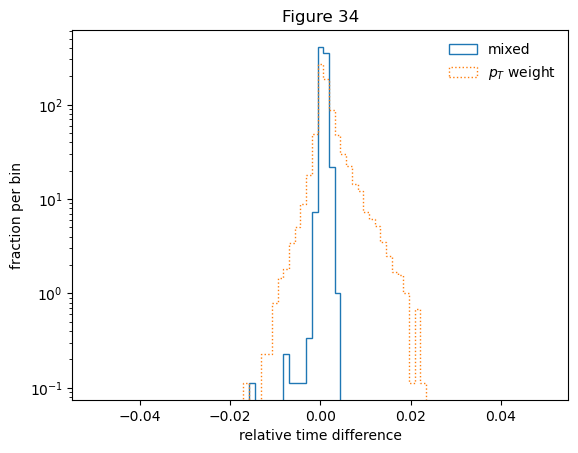

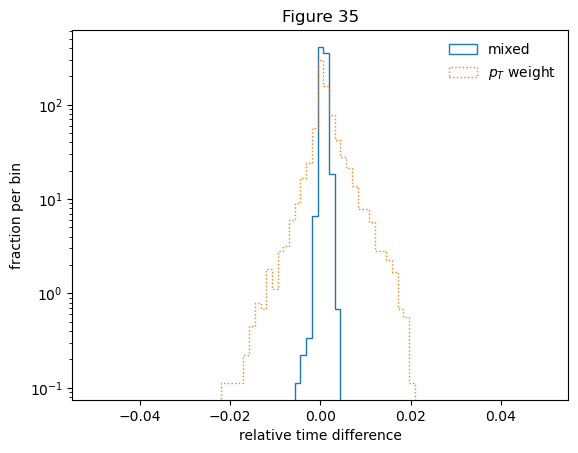

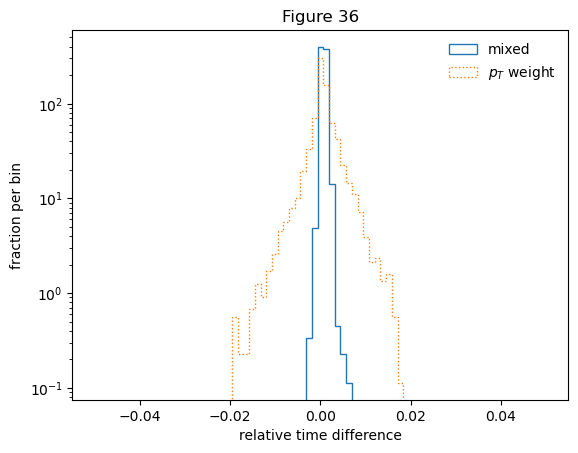

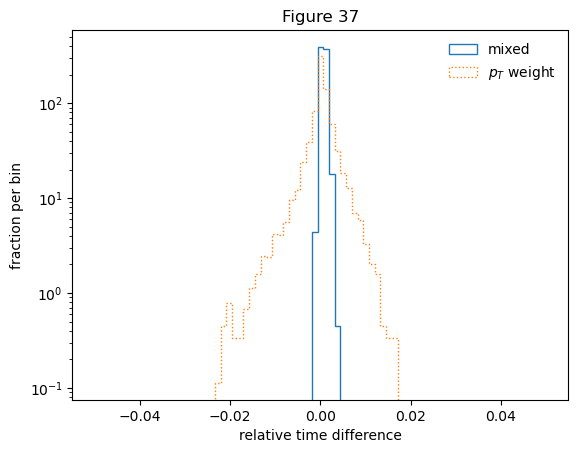

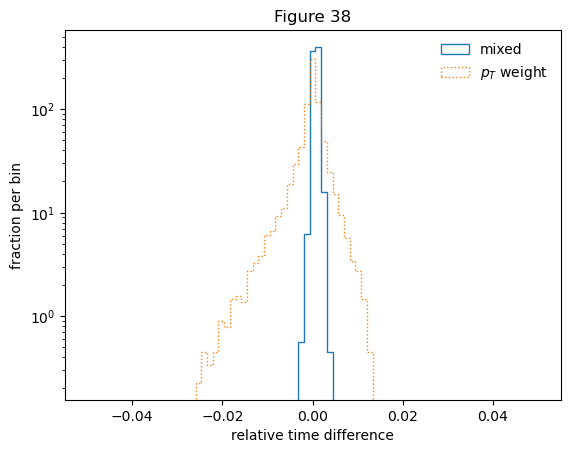

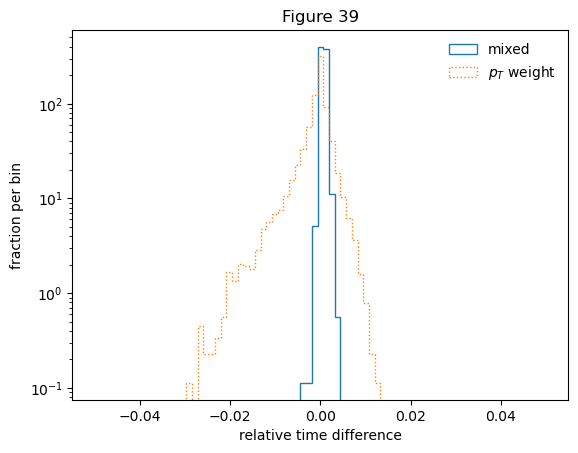

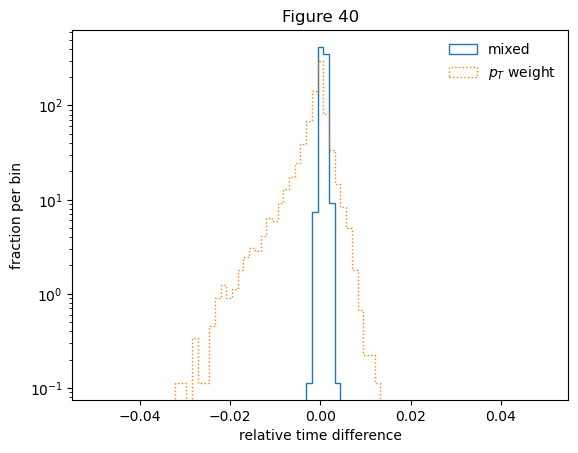

In [23]:
NNpred_list = []
pTpred_list = []

for i, eta_path in enumerate(unseenetaJ_path_list):
    test_z = unseen_input_dict["input"+eta_path][:,:,0]
    test_X = unseen_input_dict["input"+eta_path][:,:,1:]
    test_E = unseen_globale_dict["globale"+eta_path]
    test_T = unseen_globalt_dict["globalt"+eta_path]
    test_Y = unseen_label_dict["label"+eta_path]

    test_G = np.concatenate((test_E, test_T), axis=1)

    preds_unseen_mixed = mixed_efn.predict([test_z,test_X,test_G],batch_size=200)
    difference = preds_unseen_mixed/test_Y - 1
    residuals = unseen_rtd_dict["rtd"+eta_path]

    NNpred_list.append(difference)
    pTpred_list.append(residuals)

    plt.figure()
    plt.hist(difference,bins=np.linspace(-0.05,0.05,80),density=True,histtype="step",label="mixed")
    plt.hist(residuals,bins=np.linspace(-0.05,0.05,80),density=True,histtype="step",label="$p_T$ weight",ls=":")
    plt.yscale("log")
    plt.xlabel("relative time difference")
    plt.ylabel("fraction per bin")
    plt.title(f'Figure {i}')
    plt.legend(frameon=False)
plt.show()


In [24]:
np.save('NNpred_list_cat_etat_etaJ.npy', NNpred_list)
np.save('pTpred_list_cat_etet_etaJ.npy', pTpred_list)